# Tugas Besar IF3270 Pembelajaran Mesin
## Bagian A: Implementasi Forward Propagation untuk Feed Forward Neural Network

Anggota kelompok:

1. Christine Hutabarat (13520005)
2. Hana Fathiyah (13520047)
3. Yohana Golkaria Nainggolan (13520053)
4. Alifia Rahmah (13520122)



## 1. Perancangan struktur file eksternal untuk penyimpanan model

### Deklarasi Kelas

In [388]:
import networkx as nx
import matplotlib.pyplot as plt

class Case:
    def __init__(self, model, input, weights):
      self.model = Model(model["input_size"], model["layers"])
      self.input = input
      self.weights = weights

      def get_arr_neurons_weights(weights):
        arr_neurons = []
        for i in weights:
           arr_neurons.append(i[1:])
        return arr_neurons
      
      self.neuron_weights = get_arr_neurons_weights(self.weights)
      
      def get_arr_bias_weights(weights):
        arr_bias = []
        for i in weights:
           arr_bias.append(i[0])
        return arr_bias
      
      self.bias_weights = get_arr_bias_weights(self.weights)

    def draw_compact_structure(self):
        # input layer
        print(f'x({self.model.input_size})')
        print(' ↓ ')

        # hidden layer
        for i in range(len(self.model.layers)-1):
            print(f'h{i+1}({self.model.layers[i].number_of_neurons})\t= {self.model.layers[i].activation_function}')
            print(' ↓ ')

        # output layer
        print(f'y({self.model.layers[-1].number_of_neurons})\t= {self.model.layers[-1].activation_function}')

    def draw_structure(self):
        G = nx.Graph()

        weight_label = {}

        # input layer
        for i in range(self.model.input_size + 1): # neuron+bias
            G.add_node(f'x{i}', pos=(1, i + 1)) # x1, x2, ...

        # hidden layer
        if len(self.model.layers) > 1:
            for i in range(len(self.model.layers) - 1): # layer+bias
                for j in range(self.model.layers[i].number_of_neurons + 1): # neuron+bias
                    G.add_node(f'h{i+1}{j}', pos=((i + 2) * 2, j + 1)) # hi0, hi1, .., hij

                    if (j > 0): # other than bias
                        if (i == 0):
                            # first hidden layer
                            for k in range(self.model.input_size + 1): # input layer neuron
                                G.add_edge(f'x{k}', f'h{i+1}{j}')
                                weight_label[(f'x{k}', f'h{i+1}{j}')] = self.weights[i][k][j-1]
                        else:
                            # previous hidden layer neurons
                            for k in range(self.model.layers[i-1].number_of_neurons + 1):
                                G.add_edge(f'h{i}{k}', f'h{i+1}{j}')
                                weight_label[(f'h{i}{k}', f'h{i+1}{j}')] = self.weights[i][k][j-1]

            # output layer
            for i in range(self.model.layers[-1].number_of_neurons): # neurons in output layer
                G.add_node(f'o{i+1}', pos=((len(self.model.layers) + 1) * 2, i+2))
                for j in range(self.model.layers[-1].number_of_neurons + 1):
                    G.add_edge(f'h{len(self.model.layers)-1}{j}', f'o{i+1}')
                    weight_label[f'h{len(self.model.layers)-1}{j}', f'o{i+1}'] = self.weights[-1][j][i]

        else: # only input-output layer
            for i in range(self.model.layers[-1].number_of_neurons):
                G.add_node(f'o{i+1}', pos=((len(self.model.layers) + 1) * 2, i+2))
                for j in range(self.model.input_size + 1):
                    G.add_edge(f'x{j}', f'o{i+1}')
                    weight_label[f'x{j}', f'o{i+1}'] = self.weights[-1][j][i]

        pos = nx.get_node_attributes(G, 'pos')
        fig, ax = plt.subplots()
        nx.draw_networkx_nodes(G, pos, ax=ax, node_size=1000)
        nx.draw_networkx_edges(G, pos, ax=ax)
        labels = {n: n for n in G.nodes()}
        nx.draw_networkx_labels(G, pos, labels, font_color='white', ax=ax)
        nx.draw_networkx_edge_labels(G, pos, weight_label, ax=ax)
        ax.set_xticks([])
        ax.set_yticks([])

        self.print_weight_labels(weight_label)

        plt.show()

    def print_weight_labels(self, weight_label):
        print("Daftar bobot:")

        # filter input weights
        x = dict(filter(lambda w: 'x' in w[0][0], weight_label.items()))
        for i in sorted(x.items()):
            print(i[0], '→', i[1])

        # the rest
        h = dict(filter(lambda w: 'h' in w[0][0], weight_label.items()))
        for i in sorted(h.items()):
            print(i[0], '→', i[1])

class Model:
    def __init__(self, input_size, layers):
        self.input_size = input_size

        def create_array_layer(layers):
            arr_layers = []
            for i in range(len(layers)):
                arr_layers.append(Layers(layers[i]["number_of_neurons"], layers[i]["activation_function"]))
            return arr_layers

        self.layers = create_array_layer(layers)
        self.cnt_layers = len(self.layers)

class Layers:
    def __init__ (self, number_of_neurons, activation_function):
        self.number_of_neurons = number_of_neurons
        self.activation_function = activation_function

    def __str__ (self):
        return f'number of neurons: {self.number_of_neurons}\nactivation_function: {self.activation_function}\n'

class Expect:
    def __init__ (self, output, max_sse):
        self.output = output
        self.max_sse = max_sse

### Deklarasi Fungsi Aktivasi

In [389]:
# Helper function
from math import exp

# net -> persamaan linear (ax+b+...)

def linear(net):
    return net

def relu(net):
    return max(0, net)

def sigmoid(net):
    return float(1/(1 + exp(net * -1)))

def softmax(net_i, arr_net):
    net_sum = 0
    for i in arr_net:
        net_sum += exp(i)

    return float(exp(net_i)/net_sum)

### Deklarasi Fungsi Pembanding (Menghitung SSE)


In [390]:
def count_sse(predict_output, expect_output):
    sse = 0.0
    
    # print predict_output
    print("predict = [", end = "")
    for i in range(len(expect_output)):
        print(predict_output[i], end="")
        if(i < len(expect_output) - 1):
            print(",", end = " ")
    print("]")

    # print expect_output
    print(f"expect = {expect_output}")

    for i in range(len(expect_output)):
        sse += (expect_output[i] - predict_output[i]) ** 2
    return sse

## 2. Implementasi load dari file teks

In [391]:
import json

def load_file(filename):
    f = open(filename)

    data = json.load(f)

    # get model
    model = data["case"]["model"]

    # get input data
    arr_input = data["case"]["input"]

    # get weights data
    arr_weight = data["case"]["weights"]

    expect_output = data["expect"]["output"]
    expect_max_sse = data["expect"]["max_sse"]

    # create object case
    case = Case(model, arr_input, arr_weight)
    expect = Expect(expect_output, expect_max_sse)

    f.close()

    return case, expect

## 3. Implementasi forward propagation

In [392]:
import numpy as np

def forward_propagation(case):
    # create array of output
    output = []

    # print count input
    print(f'{len(case.input)} Input')

    # loop for every input
    for i in range(len(case.input)):
        print("************************************")
        current_data = [case.input[i]]

        # print input idx
        print(f"input ke-{i+1}")

        # print input layer
        print(f"input layer has {len(case.input[i])} neurons")

        # print neurons
        print(f"input neurons:")
        print('x0 (bias) = 1')
        for j in range(len(case.input[i])):
            print(f'x{j+1} = {case.input[i][j]}')

        print("==================================")

        # print count of Hidden Layer
        print(f"{case.model.cnt_layers - 1} Hidden layer")

        # loop for every layer
        for j in range(case.model.cnt_layers):

            kombinasilinear = np.dot(current_data, case.neuron_weights[j]) + case.bias_weights[j]
            current_data = kombinasilinear

            current_data_cpy = current_data.copy()

            if( j == case.model.cnt_layers - 1):
                # print output layer
                print("==================================")
                print("Output layer")

            if (j < case.model.cnt_layers - 1):
                # print hidden layer
                print('----------------------------------')
                print(f"Hidden layer ke-{j+1}: {len(current_data[0])} neurons")
            else:
                # print output layer
                print(f"Output layer has {len(current_data[0])} neurons")

            # print bias
            if (j < case.model.cnt_layers - 1):
                print(f"n{j+1}0 (bias) = 1")

            # loop for every neuron
            for k in range(len(current_data[0])):

                if (case.model.layers[j].activation_function == "linear"):
                    current_data[0][k] = linear(current_data[0][k])
                if (case.model.layers[j].activation_function == "relu"):
                    current_data[0][k] = relu(current_data[0][k])
                if (case.model.layers[j].activation_function == "sigmoid"):
                    current_data[0][k] = sigmoid(current_data[0][k])
                if (case.model.layers[j].activation_function == "softmax"):
                    current_data[0][k] = softmax(
                        current_data_cpy[0][k], current_data_cpy[0])

                if (j < case.model.cnt_layers - 1):
                    # neuron in hidden layer
                    print(f"n{j+1}{k+1} = {current_data[0][k]}")
                else:
                    # neuron in output layer
                    print(f"o{j+1}{k+1} = {current_data[0][k]}")

        output.append(current_data)
        print("************************************")
    return output

### a. Menampilkan struktur jaringan

#### linear.json

In [393]:
case_linear = load_file("linear.json")[0]
case_linear.draw_compact_structure()

x(2)
 ↓ 
y(3)	= linear


Daftar bobot:
('x0', 'o1') → 0.2
('x0', 'o2') → 0.3
('x0', 'o3') → 0.1
('x1', 'o1') → 0.5
('x1', 'o2') → 0.2
('x1', 'o3') → -0.8
('x2', 'o1') → 0.3
('x2', 'o2') → -0.6
('x2', 'o3') → 0.4


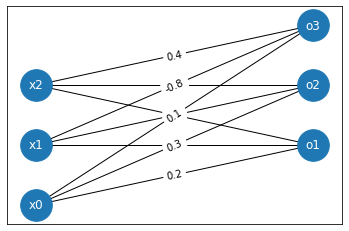

In [394]:
case_linear.draw_structure()

#### relu.json

In [395]:
case_relu = load_file("relu.json")[0]
case_relu.draw_compact_structure()

x(2)
 ↓ 
y(3)	= relu


Daftar bobot:
('x0', 'o1') → 0.1
('x0', 'o2') → 0.2
('x0', 'o3') → 0.3
('x1', 'o1') → 0.4
('x1', 'o2') → -0.5
('x1', 'o3') → 0.6
('x2', 'o1') → 0.7
('x2', 'o2') → 0.8
('x2', 'o3') → -0.9


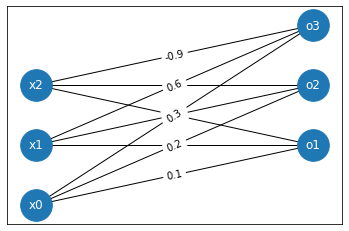

In [396]:
case_relu.draw_structure()

#### sigmoid.json

In [397]:
case_sigmoid = load_file("sigmoid.json")[0]
case_sigmoid.draw_compact_structure()

x(2)
 ↓ 
y(3)	= sigmoid


Daftar bobot:
('x0', 'o1') → 0.4
('x0', 'o2') → 0.2
('x0', 'o3') → 0.1
('x1', 'o1') → 0.2
('x1', 'o2') → 0.4
('x1', 'o3') → 0.2
('x2', 'o1') → 0.1
('x2', 'o2') → 0.2
('x2', 'o3') → 0.4


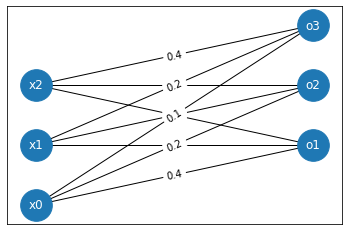

In [398]:
case_sigmoid.draw_structure()

#### softmax.json

In [399]:
case_softmax = load_file("softmax.json")[0]
case_softmax.draw_compact_structure()

x(2)
 ↓ 
y(3)	= softmax


Daftar bobot:
('x0', 'o1') → 1.0
('x0', 'o2') → 2.0
('x0', 'o3') → 3.0
('x1', 'o1') → 2.0
('x1', 'o2') → 1.0
('x1', 'o3') → 3.0
('x2', 'o1') → 3.0
('x2', 'o2') → 2.0
('x2', 'o3') → 1.0


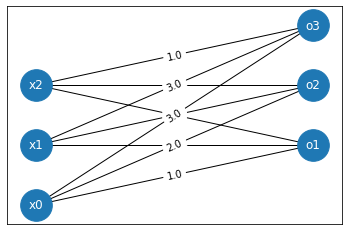

In [400]:
case_softmax.draw_structure()

#### multilayer.json

In [401]:
case_multilayer = load_file("multilayer.json")[0]
case_multilayer.draw_compact_structure()

x(2)
 ↓ 
h1(2)	= linear
 ↓ 
y(2)	= relu


Daftar bobot:
('x0', 'h11') → 0.5
('x0', 'h12') → 0.5
('x1', 'h11') → 0.0
('x1', 'h12') → -2.0
('x2', 'h11') → -1.0
('x2', 'h12') → 0.0
('h10', 'o1') → 0.5
('h10', 'o2') → 0.5
('h11', 'o1') → 0.0
('h11', 'o2') → -3.0
('h12', 'o1') → -1.0
('h12', 'o2') → 0.0


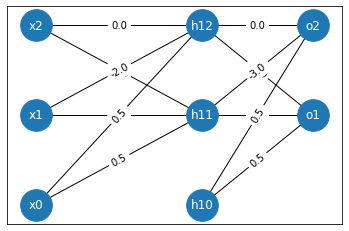

In [402]:
case_multilayer.draw_structure()

### b. Memprediksi output untuk input 1 instance

In [403]:
case_one_instance_data = {
        "model": {
            "input_size": 3,
            "layers": [
                {
                    "number_of_neurons": 4,
                    "activation_function": "relu"
                },
                {
                    "number_of_neurons": 3,
                    "activation_function": "sigmoid"
                },
                {
                    "number_of_neurons": 2,
                    "activation_function": "softmax"
                },
                {
                    "number_of_neurons": 2,
                    "activation_function": "linear"
                }
            ]
        },
        "input": [
            [
                7.0,
                2.4,
                3.6
            ]
        ],
        "weights": [
            [
                [
                    0.6,
                    0.2,
                    1.8,
                    2.5
                ],
                [
                    2.5,
                    1.2,
                    -0.3,
                    1.4
                ],
                [
                    0.6,
                    -0.3,
                    0.7,
                    1.2
                ],
                [
                    2.2,
                    -1.3,
                    0.6,
                    1.4
                ]
            ],
            [
                [
                    1.4,
                    4.5,
                    2.4
                ],
                [
                    2.6,
                    1.2,
                    1.3
                ],
                [
                    1.1,
                    1.4,
                    -0.5
                ],
                [
                    0.1,
                    -0.4,
                    1.2
                ],
                [
                    2.4,
                    -1.6,
                    0.4
                ]
            ], 
            [
                [
                    0.7,
                    1.3
                ],
                [
                    0.5,
                    1.2
                ],
                                [
                    1.3,
                    -0.5
                ],
                [
                    2.2,
                    0.2
                ]
            ],
            [
                [
                    0.8,
                    1.3
                ],
                [
                    2.2,
                    -2.1
                ],
                [
                    -0.8,
                    1.7
                ]
            ]
        ]
    }

In [404]:
# get model
model_one_instance = case_one_instance_data["model"]

# get input data
arr_input_one_instance = case_one_instance_data["input"]

# get weights data
arr_weight_one_instance = case_one_instance_data["weights"]

# create object case
case_one_instance = Case(model_one_instance, arr_input_one_instance, arr_weight_one_instance)

In [405]:
case_one_instance.draw_compact_structure()

x(3)
 ↓ 
h1(4)	= relu
 ↓ 
h2(3)	= sigmoid
 ↓ 
h3(2)	= softmax
 ↓ 
y(2)	= linear


Daftar bobot:
('x0', 'h11') → 0.6
('x0', 'h12') → 0.2
('x0', 'h13') → 1.8
('x0', 'h14') → 2.5
('x1', 'h11') → 2.5
('x1', 'h12') → 1.2
('x1', 'h13') → -0.3
('x1', 'h14') → 1.4
('x2', 'h11') → 0.6
('x2', 'h12') → -0.3
('x2', 'h13') → 0.7
('x2', 'h14') → 1.2
('x3', 'h11') → 2.2
('x3', 'h12') → -1.3
('x3', 'h13') → 0.6
('x3', 'h14') → 1.4
('h10', 'h21') → 1.4
('h10', 'h22') → 4.5
('h10', 'h23') → 2.4
('h11', 'h21') → 2.6
('h11', 'h22') → 1.2
('h11', 'h23') → 1.3
('h12', 'h21') → 1.1
('h12', 'h22') → 1.4
('h12', 'h23') → -0.5
('h13', 'h21') → 0.1
('h13', 'h22') → -0.4
('h13', 'h23') → 1.2
('h14', 'h21') → 2.4
('h14', 'h22') → -1.6
('h14', 'h23') → 0.4
('h20', 'h31') → 0.7
('h20', 'h32') → 1.3
('h21', 'h31') → 0.5
('h21', 'h32') → 1.2
('h22', 'h31') → 1.3
('h22', 'h32') → -0.5
('h23', 'h31') → 2.2
('h23', 'h32') → 0.2
('h30', 'o1') → 0.8
('h30', 'o2') → 1.3
('h31', 'o1') → 2.2
('h31', 'o2') → -2.1
('h32', 'o1') → -0.8
('h32', 'o2') → 1.7


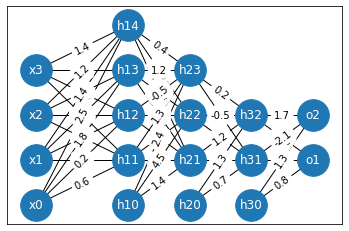

In [406]:
case_one_instance.draw_structure()

In [407]:
output_one_instance = forward_propagation(case_one_instance)
print(output_one_instance)

1 Input
************************************
input ke-1
input layer has 3 neurons
input neurons:
x0 (bias) = 1
x1 = 7.0
x2 = 2.4
x3 = 3.6
3 Hidden layer
----------------------------------
Hidden layer ke-1: 4 neurons
n10 (bias) = 1
n11 = 27.460000000000004
n12 = 3.2000000000000006
n13 = 3.54
n14 = 20.22
----------------------------------
Hidden layer ke-2: 3 neurons
n20 (bias) = 1
n21 = 1.0
n22 = 0.9997153598140323
n23 = 1.0
----------------------------------
Hidden layer ke-3: 2 neurons
n30 (bias) = 1
n31 = 0.9241058943697005
n32 = 0.07589410563029957
Output layer
Output layer has 2 neurons
o41 = 2.772317683109102
o42 = -0.5116023986048619
************************************
[array([[ 2.77231768, -0.5116024 ]])]


### c. Memprediksi output untuk input sejumlah instance

In [408]:
case_multi_instances_data = {
        "model": {
            "input_size": 2,
            "layers": [
                {
                    "number_of_neurons": 2, 
                    "activation_function": "linear"
                },
                {
                    "number_of_neurons": 2, 
                    "activation_function": "sigmoid"
                }
            ]
        },
        "input": [
            [
                1.0,
                2.0
            ],
            [
                1.0,
                0.0
            ],
            [
                0.0,
                2.0
            ]
        ],
        "weights": [
            [
                [
                    0.5,
                    0.5
                ],
                [
                    0.5,
                    0.0
                ],
                [
                    0.0,
                    0.0
                ]
            ],
            [
                [
                    -1.0,
                    0.5
                ],
                [
                    0.5,
                    -0.5
                ],
                [
                    0.0,
                    1.0
                ]
            ]
        ]
    }

In [409]:
# get model
model_multi_instances = case_multi_instances_data["model"]

# get input data
arr_input_multi_instances = case_multi_instances_data["input"]

# get weights data
arr_weight_multi_instances = case_multi_instances_data["weights"]

# create object case
case_multi_instances = Case(model_multi_instances, arr_input_multi_instances, arr_weight_multi_instances)

In [410]:
# TODO: move to menampilkan struktur jaringan
case_multi_instances.draw_compact_structure()

x(2)
 ↓ 
h1(2)	= linear
 ↓ 
y(2)	= sigmoid


Daftar bobot:
('x0', 'h11') → 0.5
('x0', 'h12') → 0.5
('x1', 'h11') → 0.5
('x1', 'h12') → 0.0
('x2', 'h11') → 0.0
('x2', 'h12') → 0.0
('h10', 'o1') → -1.0
('h10', 'o2') → 0.5
('h11', 'o1') → 0.5
('h11', 'o2') → -0.5
('h12', 'o1') → 0.0
('h12', 'o2') → 1.0


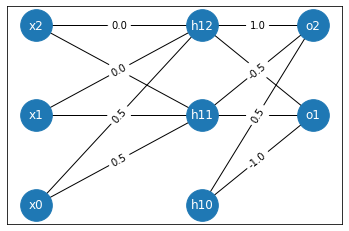

In [411]:
# TODO: move to menampilkan struktur jaringan
case_multi_instances.draw_structure()

In [412]:
output_multi_instances = forward_propagation(case_multi_instances)

3 Input
************************************
input ke-1
input layer has 2 neurons
input neurons:
x0 (bias) = 1
x1 = 1.0
x2 = 2.0
1 Hidden layer
----------------------------------
Hidden layer ke-1: 2 neurons
n10 (bias) = 1
n11 = 1.0
n12 = 0.5
Output layer
Output layer has 2 neurons
o21 = 0.3775406687981454
o22 = 0.6224593312018546
************************************
************************************
input ke-2
input layer has 2 neurons
input neurons:
x0 (bias) = 1
x1 = 1.0
x2 = 0.0
1 Hidden layer
----------------------------------
Hidden layer ke-1: 2 neurons
n10 (bias) = 1
n11 = 1.0
n12 = 0.5
Output layer
Output layer has 2 neurons
o21 = 0.3775406687981454
o22 = 0.6224593312018546
************************************
************************************
input ke-3
input layer has 2 neurons
input neurons:
x0 (bias) = 1
x1 = 0.0
x2 = 2.0
1 Hidden layer
----------------------------------
Hidden layer ke-1: 2 neurons
n10 (bias) = 1
n11 = 0.5
n12 = 0.5
Output layer
Output layer has 2 n

## 4. Pengujian kebenaran fungsional

### a. Memprediksi kasus dengan test case linear.json


In [413]:
case_linear = load_file("linear.json")[0]
output_linear = forward_propagation(case_linear)

expect_linear = load_file("linear.json")[1]

print("Menghitung Nilai SSE")

for i in range(len(case_linear.input)):
    print('----------------------------------')
    print(f"input ke-{i+1}")
    sse = count_sse(output_linear[i][0], expect_linear.output[i])
    print(f"SSE untuk input ke-{i+1} =", sse, end = "")
    if (sse < expect_linear.max_sse):
        print(" => Result: True")
    else:
        print(" => Result: False")

1 Input
************************************
input ke-1
input layer has 2 neurons
input neurons:
x0 (bias) = 1
x1 = 3.0
x2 = 1.0
0 Hidden layer
Output layer
Output layer has 3 neurons
o11 = 2.0
o12 = 0.3000000000000001
o13 = -1.9000000000000004
************************************
Menghitung Nilai SSE
----------------------------------
input ke-1
predict = [2.0, 0.3000000000000001, -1.9000000000000004]
expect = [2.0, 0.3, -1.9]
SSE untuk input ke-1 = 2.0954117794933126e-31 => Result: True


### b. Memprediksi kasus dengan test case relu.json


In [414]:
case_relu = load_file("relu.json")[0]
output_relu = forward_propagation(case_relu)

expect_relu = load_file("relu.json")[1]

print("Menghitung Nilai SSE")

for i in range(len(case_relu.input)):
    print('----------------------------------')
    print(f"input ke-{i+1}")
    sse = count_sse(output_relu[i][0], expect_relu.output[i])
    print(f"SSE untuk input ke-{i+1} =", sse, end = "")
    if (sse < expect_relu.max_sse):
        print(" => Result: True")
    else:
        print(" => Result: False")

1 Input
************************************
input ke-1
input layer has 2 neurons
input neurons:
x0 (bias) = 1
x1 = -1.0
x2 = 0.5
0 Hidden layer
Output layer
Output layer has 3 neurons
o11 = 0.04999999999999996
o12 = 1.1
o13 = 0.0
************************************
Menghitung Nilai SSE
----------------------------------
input ke-1
predict = [0.04999999999999996, 1.1, 0.0]
expect = [0.05, 1.1, 0.0]
SSE untuk input ke-1 = 1.7333369499485123e-33 => Result: True


### c. Memprediksi kasus dengan test case softmax.json

In [415]:
case_softmax = load_file("softmax.json")[0]
output_softmax = forward_propagation(case_softmax)

expect_softmax = load_file("softmax.json")[1]

print("Menghitung Nilai SSE")

for i in range(len(case_softmax.input)):
    print('----------------------------------')
    print(f"input ke-{i+1}")
    sse = count_sse(output_softmax[i][0], expect_softmax.output[i])
    print(f"SSE untuk input ke-{i+1} =", sse, end = "")
    if (sse < expect_softmax.max_sse):
        print(" => Result: True")
    else:
        print(" => Result: False")

1 Input
************************************
input ke-1
input layer has 2 neurons
input neurons:
x0 (bias) = 1
x1 = 1.0
x2 = 2.0
0 Hidden layer
Output layer
Output layer has 3 neurons
o11 = 0.6652409557748219
o12 = 0.09003057317038045
o13 = 0.24472847105479764
************************************
Menghitung Nilai SSE
----------------------------------
input ke-1
predict = [0.6652409557748219, 0.09003057317038045, 0.24472847105479764]
expect = [0.665241, 0.090031, 0.244728]
SSE untuk input ke-1 = 4.0603201288236806e-13 => Result: True


### d. Memprediksi kasus dengan test case sigmoid.json

In [416]:
case_sigmoid= load_file("sigmoid.json")[0]
output_sigmoid = forward_propagation(case_sigmoid)

expect_sigmoid = load_file("sigmoid.json")[1]

print("Menghitung Nilai SSE")

for i in range(len(case_sigmoid.input)):
    print('----------------------------------')
    print(f"input ke-{i+1}")
    sse = count_sse(output_sigmoid[i][0], expect_sigmoid.output[i])
    print(f"SSE untuk input ke-{i+1} =", sse, end = "")
    if (sse < expect_sigmoid.max_sse):
        print(" => Result: True")
    else:
        print(" => Result: False")

1 Input
************************************
input ke-1
input layer has 2 neurons
input neurons:
x0 (bias) = 1
x1 = 0.2
x2 = 0.4
0 Hidden layer
Output layer
Output layer has 3 neurons
o11 = 0.617747874769249
o12 = 0.5890404340586651
o13 = 0.574442516811659
************************************
Menghitung Nilai SSE
----------------------------------
input ke-1
predict = [0.617747874769249, 0.5890404340586651, 0.574442516811659]
expect = [0.617747, 0.58904, 0.574442]
SSE untuk input ke-1 = 1.2207224545374987e-12 => Result: True


### e. Memprediksi kasus dengan test case multilayer.json

In [417]:
case_multilayer = load_file("multilayer.json")[0]
output_multilayer = forward_propagation(case_multilayer)

expect_multilayer = load_file("multilayer.json")[1]

print("Menghitung Nilai SSE")

for i in range(len(case_multilayer.input)):
    print('----------------------------------')
    print(f"input ke-{i+1}")
    sse = count_sse(output_multilayer[i][0], expect_multilayer.output[i])
    print(f"SSE untuk input ke-{i+1} =", sse, end = "")
    if (sse < expect_multilayer.max_sse):
        print(" => Result: True")
    else:
        print(" => Result: False")

3 Input
************************************
input ke-1
input layer has 2 neurons
input neurons:
x0 (bias) = 1
x1 = 1.0
x2 = 0.0
1 Hidden layer
----------------------------------
Hidden layer ke-1: 2 neurons
n10 (bias) = 1
n11 = 0.5
n12 = -1.5
Output layer
Output layer has 2 neurons
o21 = 2.0
o22 = 0.0
************************************
************************************
input ke-2
input layer has 2 neurons
input neurons:
x0 (bias) = 1
x1 = 0.0
x2 = 1.0
1 Hidden layer
----------------------------------
Hidden layer ke-1: 2 neurons
n10 (bias) = 1
n11 = -0.5
n12 = 0.5
Output layer
Output layer has 2 neurons
o21 = 0.0
o22 = 2.0
************************************
************************************
input ke-3
input layer has 2 neurons
input neurons:
x0 (bias) = 1
x1 = 0.0
x2 = 0.0
1 Hidden layer
----------------------------------
Hidden layer ke-1: 2 neurons
n10 (bias) = 1
n11 = 0.5
n12 = 0.5
Output layer
Output layer has 2 neurons
o21 = 0.0
o22 = 0.0
*******************************